In [1]:
import os
os.chdir('..')

In [2]:
import torch
import numpy as np

from instance_generator import sample_instances
from gnn_library.util import train, save, load, gen_train_input
from evaluate import evaluate_model
from params import *
from util import upload_meta_experiment, load_meta_experiments, \
    graph_config_to_string, _plot_meta_ratios

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')
print("PyTorch has version {}".format(torch.__version__))
print('Using device:', device)

PyTorch has version 1.12.0+cu102
Using device: cuda:7


## Train meta-GNN

In [3]:
GNN1, args1 = load('GNN_large_6_10', device)
GNN2, args2 = load('GNN_large_10_6', device)

In [4]:
args = {
    'processor':         'DeeperGCN',
    'head':              'meta',
    'num_layers':        4,
    'num_mlp_layers':    2,
    'aggr':              'max',
    'batch_size':        6,
    'node_feature_dim':  7,
    'edge_feature_dim':  1,
    'graph_feature_dim': 2,
    'hidden_dim':        8,
    'output_dim':        2,
    'head_mlp_dim':      8,
    'dropout':           0,
    'epochs':            35,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.001,
    'device':            device
}

# train_loader, val_loader = gen_train_input(META_TRAIN_CONFIG, args, seed=0, base_models=[GNN1, GNN2])
# _, _, _, META_GNN, _ = train(train_loader, val_loader, args)
# save(META_GNN, args, 'META_GNN')


## Regime generalization experiment

#### Compute meta-GNN CRs over all graph configurations and node ratio regimes

In [5]:
META_GNN, args = load('META_GNN', device)

In [6]:
seed = 0
rng = np.random.default_rng(seed)
num_trials = 50
batch_size = 100
graph_configs = ALL_TESTING_GRAPH_CONFIGS
node_configs = EXPERIMENT_META_REGIMES #TODO REMOVE in line (made it smaller)
baselines_kwargs = {
    'greedy': {},
    'greedy_t': {'threshold': 0.35},
    'lp_rounding': {'rng': rng},
    'naor_lp_rounding': {'rng': rng},
    'pollner_lp_rounding': {'rng': rng}
}

regimes = [x/y for (x,y) in node_configs]

def _init_data():
    return {
        "num_trials": num_trials,
        "meta_gnn": [],
        "greedy": [],
        "greedy_t": [],
        "lp_rounding": [],
        "naor_lp_rounding": [],
        "pollner_lp_rounding": [],
        "meta_threshold": []
    }

# for graph_config in graph_configs:
#     data = _init_data()
#     graph_str = graph_config_to_string(graph_config)

#     for i, node_config in enumerate(node_configs):
#         print(graph_config, node_config)
#         instances = sample_instances(
#             *node_config,
#             num_trials,
#             rng,
#             args.__dict__,
#             **graph_config
#         )

#         rng = np.random.default_rng(seed)
#         crs, _ = evaluate_model(
#             meta_model=META_GNN,
#             meta_model_type='gnn',
#             base_models=[GNN1, GNN2],
#             instances=instances,
#             batch_size=batch_size,
#             rng=rng,
#             num_realizations=5,
#             baselines=['greedy', 'greedy_t', 'lp_rounding'],
#             **baselines_kwargs
#         )
        
#         # rng = np.random.default_rng(seed)
#         # threshold_crs, _ = evaluate_model(
#         #     meta_model=None,
#         #     meta_model_type='threshold',
#         #     base_models=[GNN1, GNN2],
#         #     instances=instances,
#         #     batch_size=batch_size,
#         #     rng=rng,
#         #     num_realizations=5
#         # )

#         data['meta_gnn'].append(crs['learned'])
#         data['greedy'].append(crs['greedy'])
#         data['greedy_t'].append(crs['greedy_t'])
#         data['lp_rounding'].append(crs['lp_rounding'])
#         # data['naor_lp_rounding'].append(crs['naor_lp_rounding'])
#         # data['pollner_lp_rounding'].append(crs['pollner_lp_rounding'])
#         # data['meta_threshold'].append(threshold_crs['learned'])

#     upload_meta_experiment(graph_str, data)

In [18]:
for key in data.keys():
    if key != 'num_trials' and key != 'meta_threshold':
        print(key, np.mean(data[key]))

meta_gnn 0.9479576212964802
greedy 0.8945135372423482
greedy_t 0.8183626422237713
lp_rounding 0.9390001265099697
naor_lp_rounding nan
pollner_lp_rounding nan


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


#### Generate regime generalization plots

dict_keys(['ER_0.5', 'OSMNX_Fremont, California, USA'])


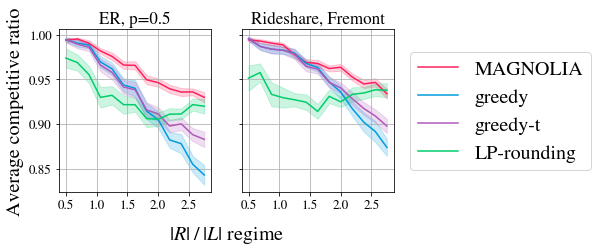

In [20]:
from util import _plot_meta_ratios_main
results = load_meta_experiments(MAIN_TESTING_GRAPH_CONFIGS)
# _plot_meta_ratios(
#     regimes,
#     results,
#     ['meta_gnn', 'greedy', 'greedy_t', 'lp_rounding'],
#     lambda graph_type: graph_type,
#     confidence = 0.95
# )
results.pop('GEOM_0.25')
results.pop('GM')
print(results.keys())
_plot_meta_ratios_main(
    regimes,
    results,
    ['meta_gnn', 'greedy', 'greedy_t', 'lp_rounding'],
    lambda graph_type: graph_type,
    confidence = 0.95
)

In [ ]:
data = load_meta_experiments(graph_configs)